In [1]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft2, ifft2, fftshift
from io import BytesIO
import colour



def generate_blue_noise_spectral(h,w):
    white_noise = np.random.rand(h, w) * 255
    
    f_noise = fft2(white_noise)
    f_noise = fftshift(f_noise) 

    x, y = np.meshgrid(np.linspace(-1, 1, h), np.linspace(-1, 1, w))
    radius = np.sqrt(x**2 + y**2)
    filter_mask = radius > 0.3 
    f_noise_filtered = f_noise.T * filter_mask

    blue_noise = np.real(ifft2(fftshift(f_noise_filtered)))

    blue_noise = (blue_noise - blue_noise.min()) / (blue_noise.max() - blue_noise.min()) * 255
    return blue_noise.astype(np.uint8)

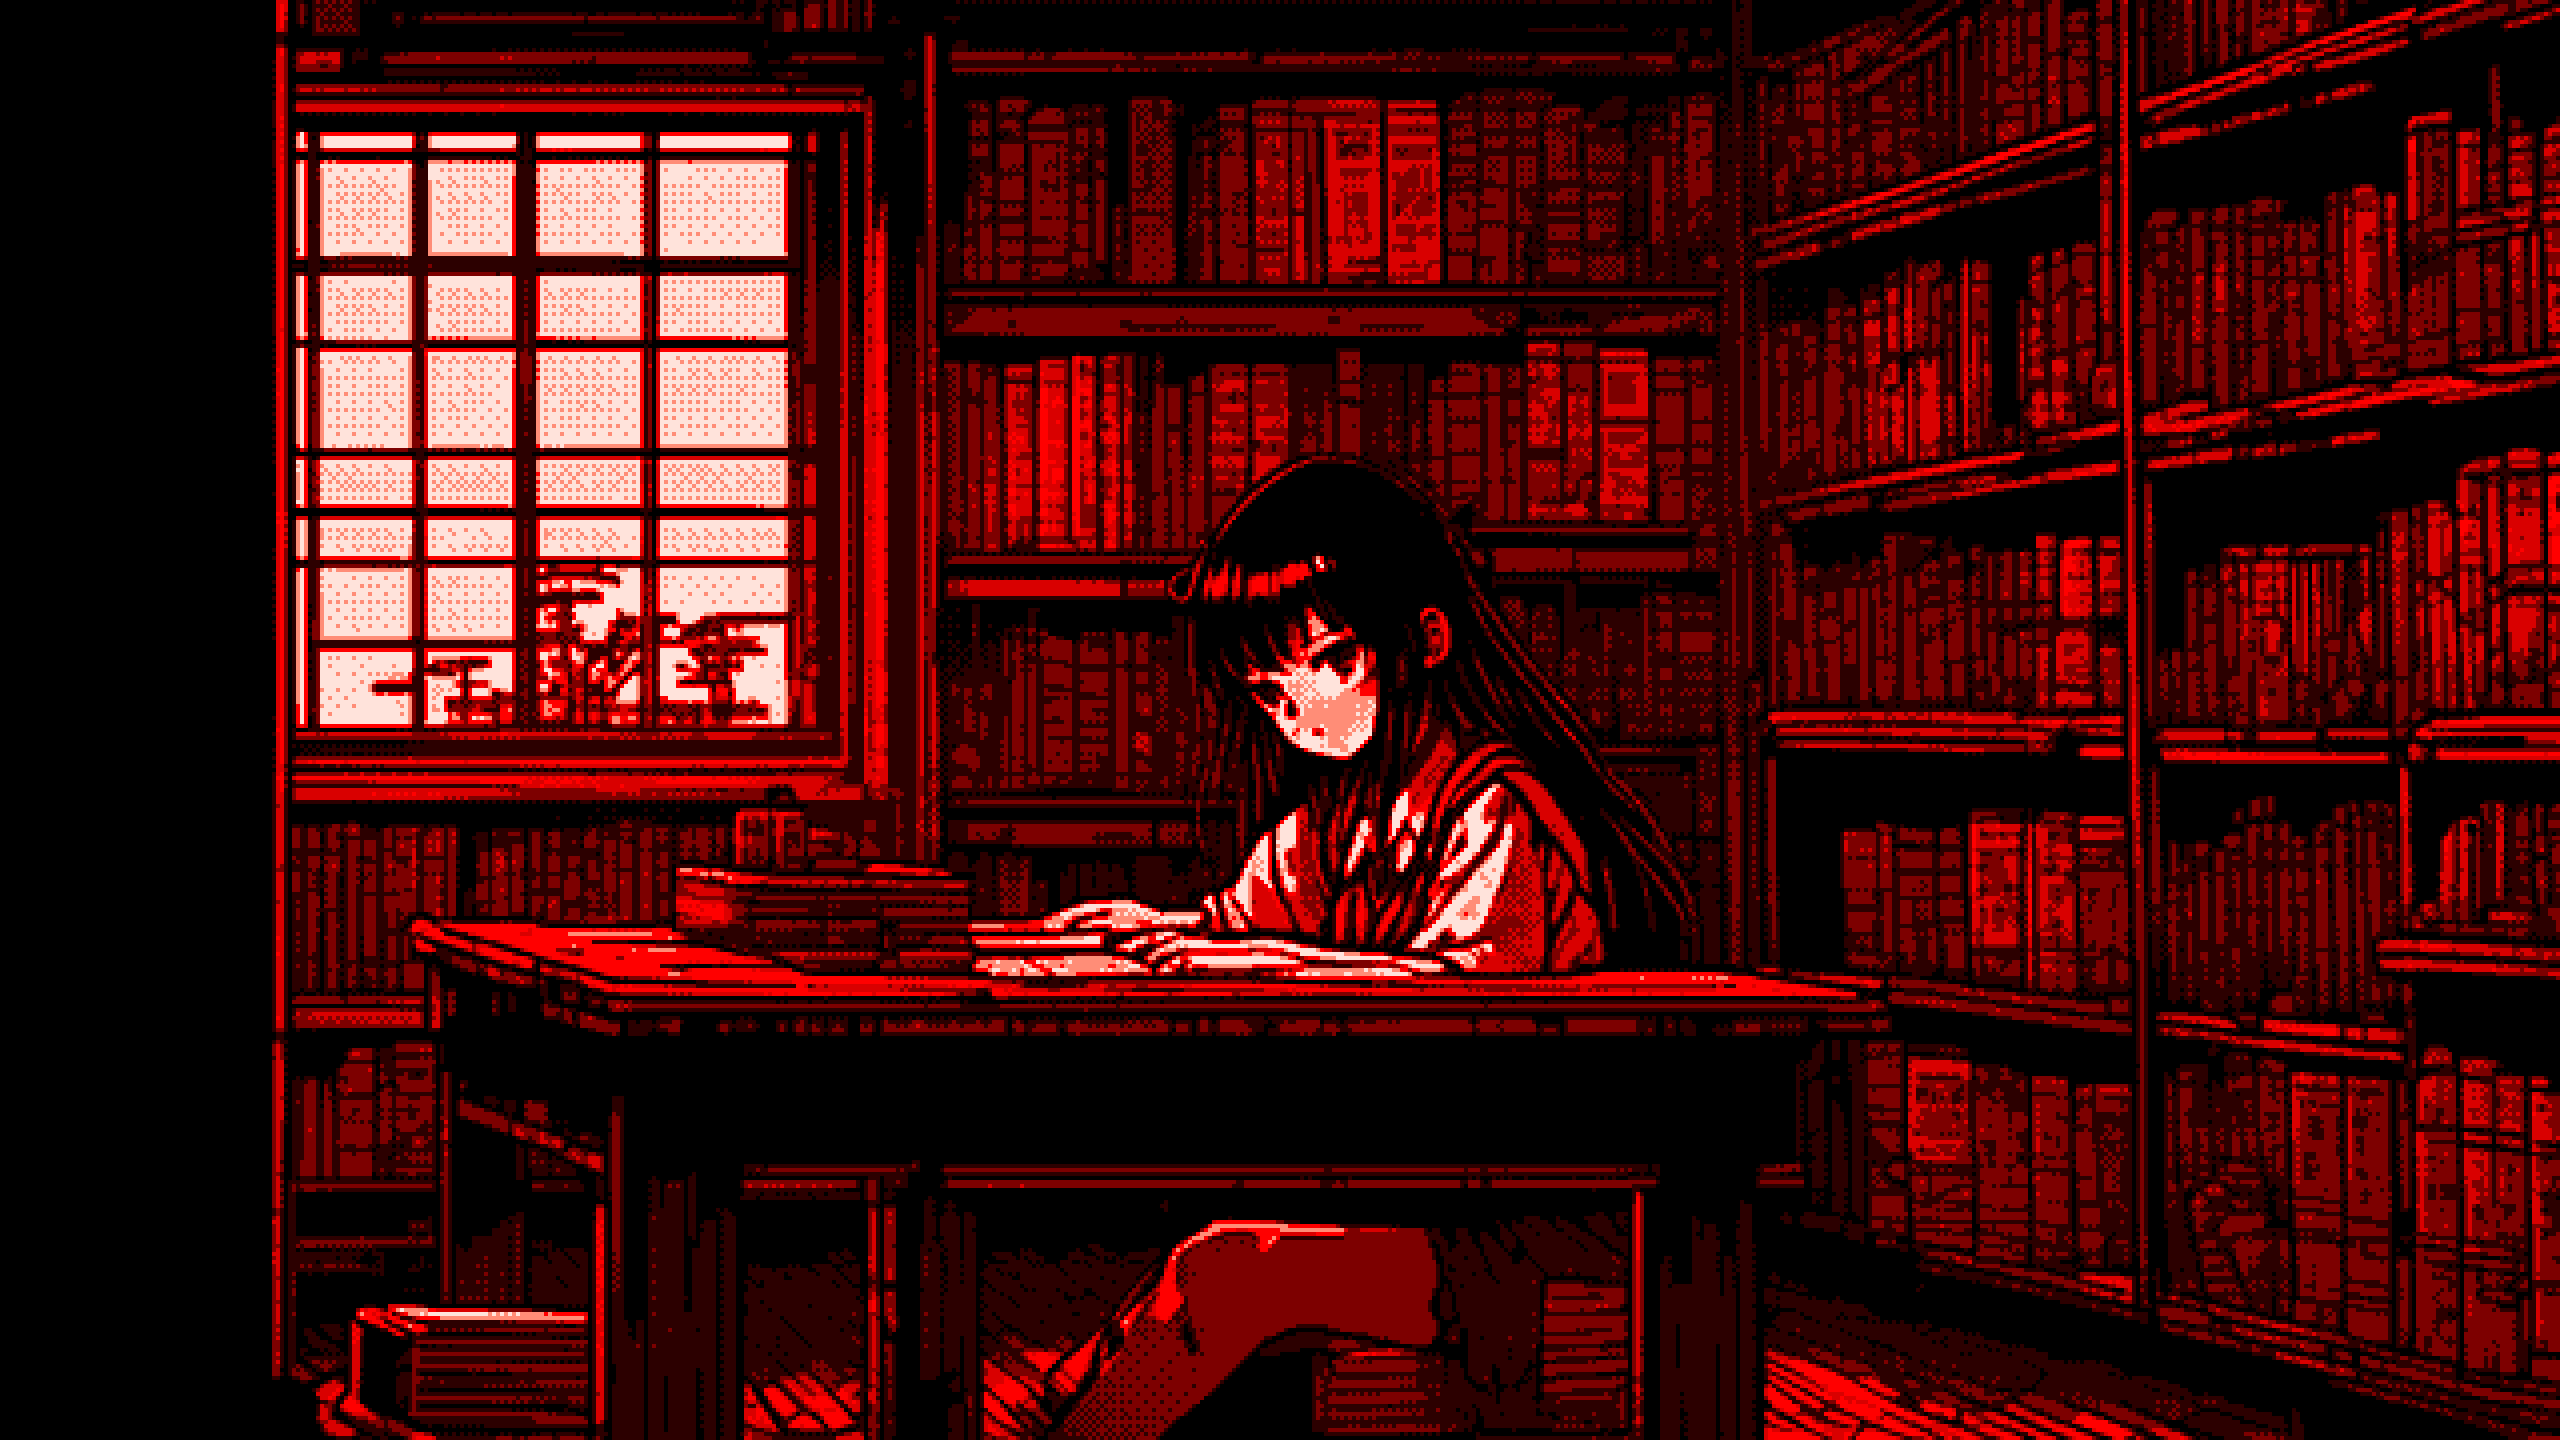

In [200]:
im = Image.open(r"ComfyUI_00770_.png")

im
oldsize = np.array(im.size)
newsize_w, newsize_h = np.array(im.size)
newsize_h *= .5
newsize_w *= .5

#newsize_h = 720//2
#newsize_w = 1240//2 
newsize_h = int(newsize_h)
newsize_w = int(newsize_w)
newsize = (newsize_w,newsize_h)
blue_noise = generate_blue_noise_spectral(newsize_w,newsize_h)
blue = Image.fromarray(blue_noise)
L = im.convert(mode="L")
L = L.resize((newsize_w,newsize_h), Image.LANCZOS)
R = L.convert(mode="RGB")

P = L.convert(mode="RGB")

plus_dither_matrix = np.array([
    [ 0 ,  8 ,  2 , 10 ],
    [12 ,  4 , 14 ,  6 ],
    [ 3 , 11 ,  1 ,  9 ],
    [15 ,  7 , 13 ,  5 ]
])*16
dither_height, dither_width = plus_dither_matrix.shape


# SETTINGS:
n = 8 # Number of Colors
l = np.linspace(0.0,.95,n)  # Luminance
#l = (l**1.1)/np.max(l**1.1)
hue = 30 / 180 * np.pi # Color Wheel
hue_shift = 0/180*np.pi /n # Color Shift
c = .5-np.abs(l-.5) # Chroma
r = 2.9 # Radius of Dither 


color = []
for i in range(n):
    a = c[i] * np.cos(hue)
    b = c[i] * np.sin(hue)
    hue = hue + hue_shift
    color.append(colour.XYZ_to_sRGB(colour.Oklab_to_XYZ((l[i],a,b))))
    


color = np.clip(color,0,1)*256
color = np.array(color,int)
color_int = []
for i in color:
    color_int.append(tuple(i))

#for i in range(newsize_w):
#    for j in range(newsize_h):
#        L.putpixel((i,j),256-L.getpixel((i,j)) )
        
for i in range(newsize_w):
    for j in range(newsize_h):
        p =  int((L.getpixel((i,j))+((blue.getpixel((i,j)))/(n*r)))/256*n)
        p = np.clip(p,0,n-1)
        R.putpixel((i,j),color_int[p])
        p2 =  int((L.getpixel((i,j))+(plus_dither_matrix[i % dither_height, j % dither_width])/(n*r))/256*n)
        p2 = np.clip(p2,0,n-1)
        P.putpixel((i,j),color_int[p2])


P = P.resize(tuple(oldsize*2),Image.NEAREST)
R = R.resize(tuple(oldsize*2),Image.NEAREST)
#P = P.resize(tuple([1280,720]),Image.NEAREST)
#R = R.resize(tuple([1280,720]),Image.NEAREST)
R.save("out_stochastic.jpg")
P.save("out_plus.jpg")
P


7.2517314896310445